In [1]:
import time

import neuroglancer
import numpy as np

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def convert_coor_xy_list_to_x_y_list( coordinates ):
    x_coors = []
    y_coors = []
    for coor in coordinates:
        y, x = coor
        x_coors.append( int(x) )
        y_coors.append( int(y) )
    return [x_coors, y_coors]

In [18]:
def solve_affine( p1, p2, p3, p4, s1, s2, s3, s4 ):
    x = np.transpose(np.matrix([p1,p2,p3,p4]))
    y = np.transpose(np.matrix([s1,s2,s3,s4]))
    # add ones on the bottom of x and y
    x = np.vstack((x,[1,1,1,1]))
    y = np.vstack((y,[1,1,1,1]))
    # solve for A2
    A2 = y * x.I
    # return function that takes input x and transforms it
    # don't need to return the 4th row as it is 
    return lambda x: (A2*np.vstack((np.matrix(x).reshape(3,1),1)))[0:3,:]

transformFn = solve_affine( primary_system1, primary_system2, 
                            primary_system3, primary_system4,
                            secondary_system1, secondary_system2,
                            secondary_system3, secondary_system4 )

# test: transform primary_system1 and we should get secondary_system1
np.matrix(secondary_system1).T - transformFn( primary_system1 )
# np.linalg.norm of above is 0.02555

# transform another point (x,y,z).
transformed = transformFn((x,y,z))

NameError: name 'primary_system1' is not defined

In [27]:
transformFn = solve_affine( [0,0,0], [0,0,1], 
                            [0,1,1], [1,0,1],
                            [0,0,0], [0,0,1], 
                            [0,1,1], [1,1,1] )

# # test: transform primary_system1 and we should get secondary_system1
# np.matrix(secondary_system1).T - transformFn( primary_system1 )
# # np.linalg.norm of above is 0.02555

# transform another point (x,y,z).
transformed = transformFn((0,1,1))

In [51]:
transformFn = solve_affine( [0,0,0], [1,0,0], 
                            [0,1,0], [0,0,1],
                            [0,0,0], [0,1,0], 
                            [-1,0,0], [0,0,1] )

# # test: transform primary_system1 and we should get secondary_system1
# np.matrix(secondary_system1).T - transformFn( primary_system1 )
# # np.linalg.norm of above is 0.02555

# transform another point (x,y,z).
transformed = transformFn((2,2,1))

In [52]:
transformed

matrix([[-2.],
        [ 2.],
        [ 1.]])

In [53]:
118./13

9.076923076923077

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


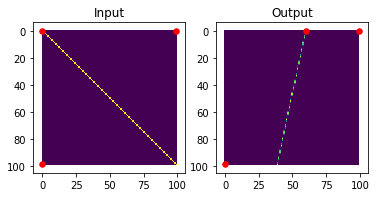

In [2]:
test_matrix = np.zeros((100,100))
for i in range(100):
    test_matrix[i,i]=1
    
test_grid = [[0,0],[4,0],[9,0],[0,4],[4,4],[9,4],[0,9],[4,9],[9,9]]

img = test_matrix
rows,cols = img.shape

pts1 = np.float32([[0,0],[99,0],[0,99]]) # [x,y]
pts2 = np.float32([[60,0],[99,0],[0,99]]) # [x,y]

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(img,M,(cols,rows))

y_coors_1, x_coors_1 = convert_coor_xy_list_to_x_y_list( pts1 )
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(121),plt.scatter(x_coors_1,y_coors_1, c='r', s=30)
y_coors_2, x_coors_2 = convert_coor_xy_list_to_x_y_list( pts2 )
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.subplot(122),plt.scatter(x_coors_2,y_coors_2, c='r', s=30)
plt.show()

In [241]:
volume = np.zeros((100,100,50))
for z in range(50):
    for i in range(100):
        volume[i,i,z]=1
        
        
grid_dict = {}
jump_x = 25
jump_y = 25
jump_z = 25
for x in range(0,101,jump_x):
    for y in range(0,101,jump_y):
        for z in range(0,51,jump_z):
            coordinates = (x,y,z)
            coordinates_str = str(coordinates)
            grid_dict[coordinates_str] = coordinates
            
grid_dict['(50, 50, 0)'] = (50,40,0)

In [421]:
volume = np.zeros((100,100,50))

for z in range(50):
    for i in range(100):
        volume[i,i,z]=1
        try:
            volume[i-1,i,z]=1
            volume[i+1,i,z]=1
            volume[i,i+1,z]=1
            volume[i+1,i+1,z]=1
            volume[i+2,i+1,z]=1
            
            volume[i+25,i,z]=1
            volume[i-25,i,z]=1
        except:
            continue

In [422]:
def get_triangle_indices_to_vertices_2d( grid_dict, triangle_type='sawtooth' ):
    """
    Sawtooth: Every point with two unique, adjacent points will create a triangle.
    """
    
    original_grid_coors = []
    
    for original_grid_pnt_str in grid_dict.keys():
        # Convert the string-key into coordinate pair
        original_grid_pnt_coors = original_grid_pnt_str.replace('(','').replace(')','').replace(' ','').split(',')
        original_grid_pnt_coors = [int(original_grid_pnt_coors[0]), \
                                   int(original_grid_pnt_coors[1]), \
                                   int(original_grid_pnt_coors[2])]
        # Add the grid point coordinates to the list of original grid point coordinates
        original_grid_coors.append( original_grid_pnt_coors )
        
    triangle_indices_to_vertices = {}
    triangle_index = 0
    
    if triangle_type=='sawtooth':
        for pnt in original_grid_coors:
            right_gridpnt = list( np.add( pnt, [jump_x,0,0] ) )
            down_gridpnt = list( np.add( pnt, [0,jump_y,0] ) )
            
            up_right_gridpnt = list( np.add( pnt, [jump_x,-jump_y,0] ) )
            
            # Check for RIGHT point and DOWN point
            if (right_gridpnt in original_grid_coors) and (up_right_gridpnt in original_grid_coors):
                triangle_indices_to_vertices[triangle_index] = [pnt, right_gridpnt, up_right_gridpnt]
                triangle_index += 1

            # Check for RIGHT point and RIGHT+UP point
            if (right_gridpnt in original_grid_coors) and (down_gridpnt in original_grid_coors):
                triangle_indices_to_vertices[triangle_index] = [pnt, right_gridpnt, down_gridpnt]
                triangle_index += 1
                
    return triangle_indices_to_vertices

def signed_area(pr2):
    """
     Return the signed area enclosed by a ring using the linear time
     algorithm at http://www.cgafaq.info/wiki/Polygon_Area. A value >= 0
     indicates a counter-clockwise oriented ring.
    """
    xs, ys = map(list, zip(*pr2))
    xs.append(xs[1])
    ys.append(ys[1])
    return sum(xs[i]*(ys[i+1]-ys[i-1]) for i in range(1, len(pr2)))/2.0

def get_mask_from_vertices( tupVerts ):
    from matplotlib.path import Path
    
    clockwise = np.sign( signed_area(tupVerts) )
    
    # Is a 2D triangle
    if np.shape(tupVerts)==(3,2):
        x_vals = [tupVerts[0,0],tupVerts[1,0],tupVerts[2,0]]
        y_vals = [tupVerts[0,1],tupVerts[1,1],tupVerts[2,1]]
        max_x = int( max(x_vals))
        min_x = int( min(x_vals))
        max_y = int( max(y_vals))
        min_y = int( min(y_vals))

    x, y = np.meshgrid(np.arange(max_x), np.arange(max_y)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(tupVerts) # make a polygon
    grid = p.contains_points(points, radius=0*clockwise)
    mask = grid.reshape( max_y, max_x ) # now you have a mask with points inside a polygon
    plt.imshow(mask)
    plt.show()
    return mask

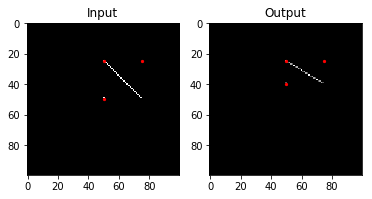

[[50. 25.]
 [75. 25.]
 [50. 40.]]


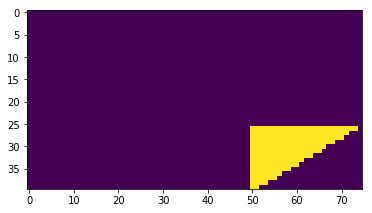

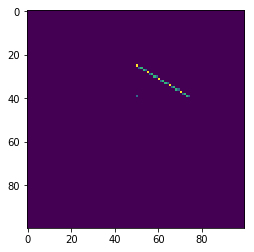

[50, 75, 25, 40]


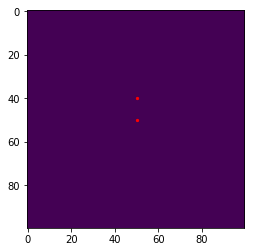

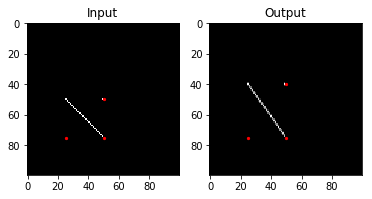

[[25. 75.]
 [50. 75.]
 [50. 40.]]


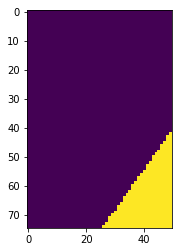

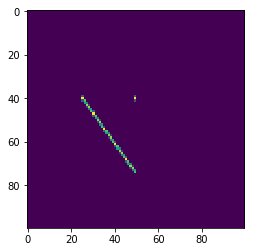

[25, 50, 40, 75]


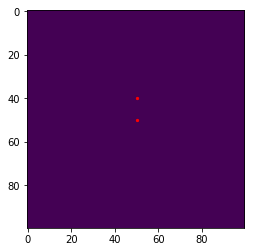

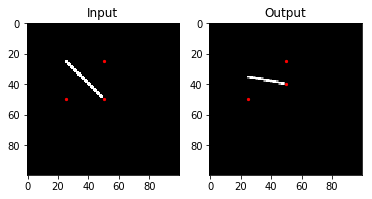

[[25. 50.]
 [50. 40.]
 [50. 25.]]


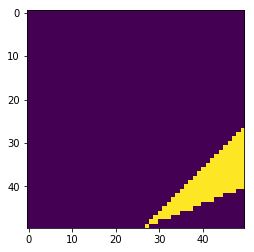

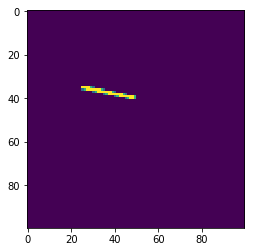

[25, 50, 25, 50]


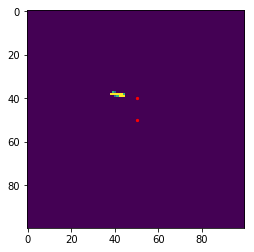

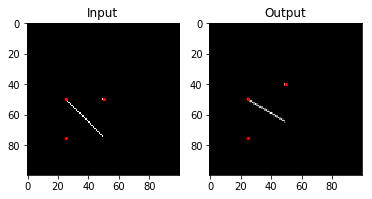

[[25. 50.]
 [50. 40.]
 [25. 75.]]


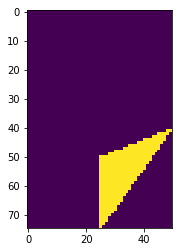

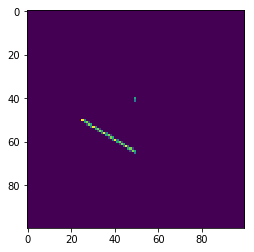

[25, 50, 40, 75]


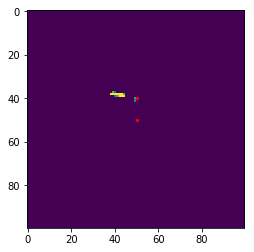

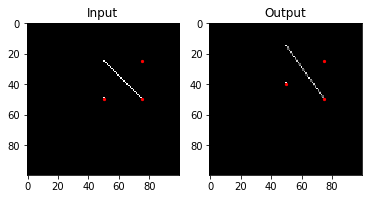

[[50. 40.]
 [75. 50.]
 [75. 25.]]


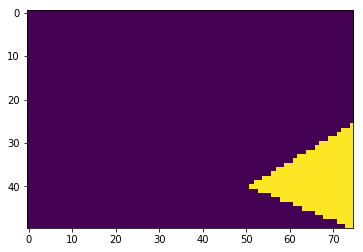

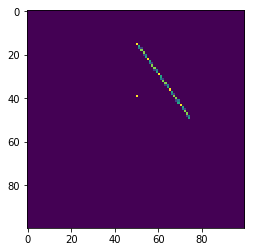

[50, 75, 25, 50]


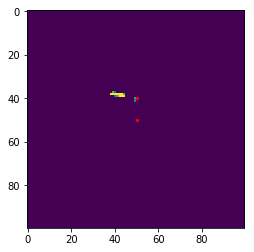

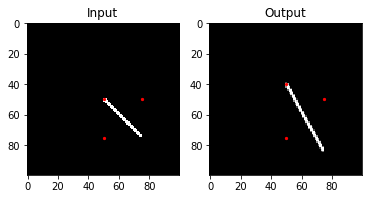

[[50. 40.]
 [75. 50.]
 [50. 75.]]


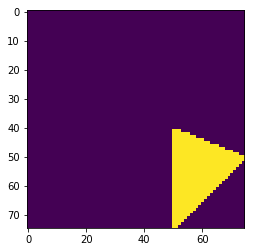

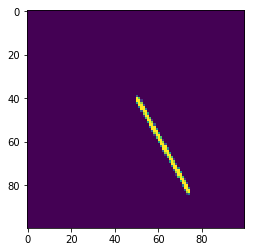

[50, 75, 40, 75]


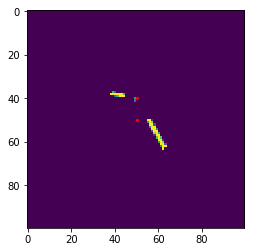

In [435]:
triangle_indices_to_vertices = get_triangle_indices_to_vertices_2d( grid_dict, triangle_type='sawtooth' )
volume_copy = volume.copy()
volume_copy = np.zeros(np.shape(volume))


for grid1_triangle_vertices in triangle_indices_to_vertices.values():
    triangle_is_distorted = False
    # Check every vertex in the triangle, if any have been changed, then set
    # `triangle_is_distorted` to True
    for coordinate_pair in grid1_triangle_vertices:
        grid1_coordinate_pair_string = str(tuple( coordinate_pair ))
        grid2_coordinate_pair_string = str(grid_dict[grid1_coordinate_pair_string])
        if grid2_coordinate_pair_string != grid1_coordinate_pair_string:
            triangle_is_distorted = True
            break
            
    # Calculate bounding boxes
    large_num = 999999999 # an arbitrarily large number guaranteed to be overwritten by smaller numbers
    grid1_min_max_x_y = [large_num,-1,large_num,-1] # minX, maxX, minY, maxY
    grid2_min_max_x_y = [large_num,-1,large_num,-1] # minX, maxX, minY, maxY
    # The for loop finds the grid2 vertices and put into this list
    grid2_triangle_vertices = []
    for grid1_coordinate_pair in grid1_triangle_vertices:
        # Update the cropping box for the grid1 points (using min/max x/y values)
        grid1_min_max_x_y[0] = min( grid1_min_max_x_y[0], grid1_coordinate_pair[0] )
        grid1_min_max_x_y[1] = max( grid1_min_max_x_y[1], grid1_coordinate_pair[0] )
        grid1_min_max_x_y[2] = min( grid1_min_max_x_y[2], grid1_coordinate_pair[1] )
        grid1_min_max_x_y[3] = max( grid1_min_max_x_y[3], grid1_coordinate_pair[1] )
        
        # Add mapped (grid1->grid2) coordinates to the grid2 vertices list
        grid1_coordinate_pair_string = str(tuple( grid1_coordinate_pair ))
        grid2_triangle_vertices.append( list(grid_dict[grid1_coordinate_pair_string]) )
        
        grid2_coordinate_pair = list(grid_dict[grid1_coordinate_pair_string])
        # Update the cropping box for the grid2 points (using min/max x/y values)
        grid2_min_max_x_y[0] = min( grid2_min_max_x_y[0], grid2_coordinate_pair[0] )
        grid2_min_max_x_y[1] = max( grid2_min_max_x_y[1], grid2_coordinate_pair[0] )
        grid2_min_max_x_y[2] = min( grid2_min_max_x_y[2], grid2_coordinate_pair[1] )
        grid2_min_max_x_y[3] = max( grid2_min_max_x_y[3], grid2_coordinate_pair[1] )
        
    
        
    # If none of the 3 vertices have been changed, copy the triangle to "volume_copy" 
    #   and then continue to the next triangle
    if not triangle_is_distorted:
#         volume_cross_section = volume_copy[:,:,z_plane]
#         rows,cols = volume_cross_section.shape
#         cropped_volume_cross_section = np.zeros( (rows,cols) )
        
#         grid1_triangle_vertices_xy = [grid1_triangle_vertices[0][0:2],
#                                       grid1_triangle_vertices[1][0:2],
#                                       grid1_triangle_vertices[2][0:2]]
#         grid1_triangle_mask = get_mask_from_vertices( grid1_triangle_vertices_xy )
#         for x in range( grid1_min_max_x_y[0], grid1_min_max_x_y[1]):
#             for y in range( grid1_min_max_x_y[2], grid1_min_max_x_y[3]):
#                 try:
#                     if grid1_triangle_mask[x,y]:
#                         volume_copy[x,y,z_plane] = warped_cropped_volume_cross_section[x,y]
#                 except:
#                     continue
        
        continue
    # If the triangle *HAS BEEN DISTORTED*
    
#     print(grid1_triangle_vertices)
#     print(grid2_triangle_vertices)
    z_plane = grid1_triangle_vertices[0][2]
    volume_cross_section = volume[:,:,z_plane].copy()
    
    # Remove the z-coordinate for this preliminary code
    grid1_triangle_vertices_xy = [grid1_triangle_vertices[0][0:2],
                                  grid1_triangle_vertices[1][0:2],
                                  grid1_triangle_vertices[2][0:2]]
    grid2_triangle_vertices_xy = [grid2_triangle_vertices[0][0:2],
                                  grid2_triangle_vertices[1][0:2],
                                  grid2_triangle_vertices[2][0:2]]
    # The affine transformation is computed using the vertices, which are relabeled as "mapping points"
    mapping_pts1 = np.float32(grid1_triangle_vertices_xy)
    mapping_pts2 = np.float32(grid2_triangle_vertices_xy)
    
    # Crop out the relevant part of the image
    rows,cols = volume_cross_section.shape
    cropped_volume_cross_section = np.zeros( (rows,cols) )
    cropped_volume_cross_section[ grid1_min_max_x_y[2]:grid1_min_max_x_y[3], \
                                  grid1_min_max_x_y[0]:grid1_min_max_x_y[1] ] = \
           volume_cross_section[ grid1_min_max_x_y[2]:grid1_min_max_x_y[3], \
                                 grid1_min_max_x_y[0]:grid1_min_max_x_y[1] ]
#     cropped_volume_cross_section = volume_cross_section[ grid1_min_max_x_y[2]:grid1_min_max_x_y[3], \
#                                  grid1_min_max_x_y[0]:grid1_min_max_x_y[1] ].copy()
#     rows,cols = cropped_volume_cross_section.shape
    
    # If the cropbox area only contains zeros, skip the transformation
    if np.count_nonzero( cropped_volume_cross_section ) == 0:
        continue

    
    # Apply the affine transformation to the cropped img
    M = cv2.getAffineTransform(mapping_pts1,mapping_pts2)
    warped_cropped_volume_cross_section = cv2.warpAffine( cropped_volume_cross_section, M, (cols,rows))

    # Plot the original (cropped) image and vertex points
    y_coors_1, x_coors_1 = convert_coor_xy_list_to_x_y_list( mapping_pts1 )
    plt.subplot(121),plt.imshow(cropped_volume_cross_section, cmap='gray'),plt.title('Input')
    plt.subplot(121),plt.scatter(x_coors_1,y_coors_1, c='r', s=5)
    # Plot the transformed (cropped) image and vertex points
    y_coors_2, x_coors_2 = convert_coor_xy_list_to_x_y_list( mapping_pts2 )
    plt.subplot(122),plt.imshow(warped_cropped_volume_cross_section, cmap='gray'),plt.title('Output')
    plt.subplot(122),plt.scatter(x_coors_2,y_coors_2, c='r', s=5)
    plt.show()
    
    print mapping_pts2
    grid2_triangle_mask = get_mask_from_vertices( mapping_pts2 )
#     if (mapping_pts2==[[25., 50.],[50., 40.],[25., 75.]]).all():
#         plt.imshow(grid2_triangle_mask)
#         plt.show()
#         sdf
    plt.imshow(warped_cropped_volume_cross_section)
    plt.show()
    print(grid2_min_max_x_y)
    for x in range( grid2_min_max_x_y[0], grid2_min_max_x_y[1]):
        for y in range( grid2_min_max_x_y[2], grid2_min_max_x_y[3]):
            if grid2_triangle_mask[y,x]:
                volume_copy[x,y,z_plane] = max(volume_copy[x,y,z_plane],warped_cropped_volume_cross_section[x,y])
                
    plt.imshow( volume_copy[:,:,z_plane] )
    
    plt.scatter([50,50],[50,40], c='r', s=5)
    plt.show()

In [432]:
grid1_triangle_vertices_xy[0]

[50, 25]

In [295]:
mapping_pts2

array([[25., 50.],
       [50., 40.],
       [25., 75.]], dtype=float32)

In [343]:
mapping_pts2

array([[25., 50.],
       [50., 40.],
       [25., 75.]], dtype=float32)

In [309]:
[[25, 50],[50, 40],[25, 75]][0]

[25, 50]

In [308]:
[[25, 50],[50, 40],[25, 75]][0,0]

TypeError: list indices must be integers, not tuple

In [326]:
get_mask_from_vertices( [[25., 50.],[50., 40.],[25., 75.]])

TypeError: list indices must be integers, not tuple

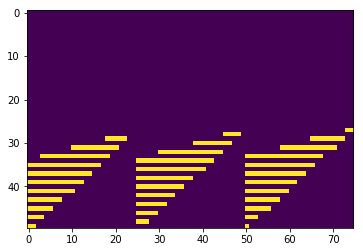

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False]])

In [298]:
get_mask_from_vertices( [[25., 50.],[50., 40.],[25., 75.]])

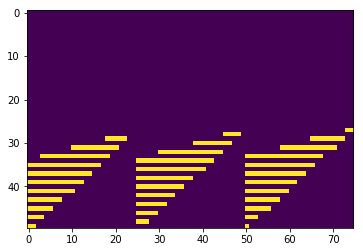

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False]])

In [293]:
get_mask_from_vertices( mapping_pts2 )

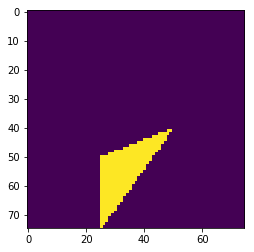

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [289]:
get_mask_from_vertices( [[25., 50.],[50., 40.],[25., 75.]])

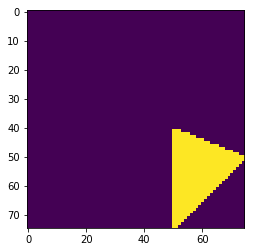

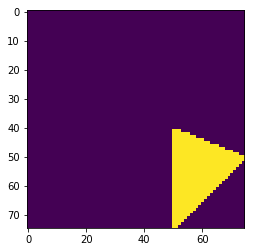

In [285]:
plt.imshow(get_mask_from_vertices( mapping_pts2))

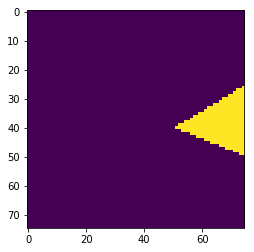

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [287]:
get_mask_from_vertices( [[50., 40.],[75., 50.],[75., 25.]])

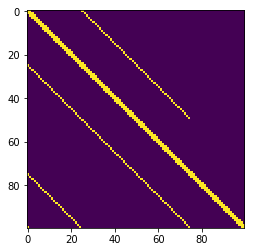

In [424]:
plt.imshow( volume[:,:,z_plane] )

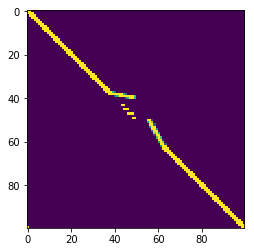

In [273]:
plt.imshow( volume_copy[:,:,z_plane] )

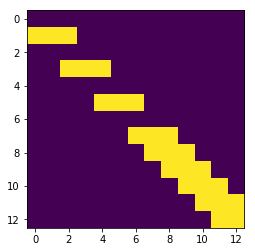

In [269]:
plt.imshow(volume_copy[42:55,42:55,z_plane])

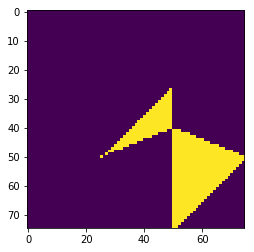

In [254]:
mask1 = get_mask_from_vertices( [[50., 40.], [75., 50.], [50., 75.]])
mask2 = get_mask_from_vertices( [[25., 50.], [50., 40.], [50., 25.]])
plt.imshow(np.add(mask1,mask2))

In [233]:
np.add(mask1,mask2)[48,48]

False

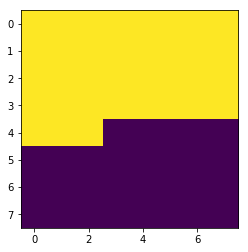

In [234]:
plt.imshow(np.add(mask1,mask2)[42:50,42:50])

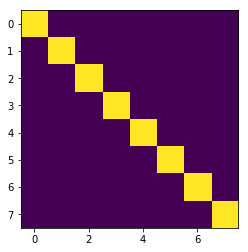

In [235]:
plt.imshow(volume_copy[42:50,42:50,1])

In [301]:
def signed_area(pr2):
    """
     Return the signed area enclosed by a ring using the linear time
     algorithm at http://www.cgafaq.info/wiki/Polygon_Area. A value >= 0
     indicates a counter-clockwise oriented ring.
    """
    xs, ys = map(list, zip(*pr2))
    xs.append(xs[1])
    ys.append(ys[1])
    return sum(xs[i]*(ys[i+1]-ys[i-1]) for i in range(1, len(pr2)))/2.0

def get_mask_from_vertices( tupVerts ):
    from matplotlib.path import Path
    
    clockwise = np.sign( signed_area(tupVerts) )
    
    # Is a 2D triangle
    if np.shape(tupVerts)==(3,2):
        x_vals = [tupVerts[0,0],tupVerts[1,0],tupVerts[2,0]]
        y_vals = [tupVerts[0,1],tupVerts[1,1],tupVerts[2,1]]
        max_x = int( max(x_vals))
        min_x = int( min(x_vals))
        max_y = int( max(y_vals))
        min_y = int( min(y_vals))

    x, y = np.meshgrid(np.arange(max_x), np.arange(max_y)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(tupVerts) # make a polygon
    grid = p.contains_points(points, radius=0*clockwise)
    mask = grid.reshape( max_x, max_y ) # now you have a mask with points inside a polygon
    plt.imshow(mask)
    plt.show()
    return mask

In [208]:
signed_area([[25., 50.], [50., 45.], [50., 25.]])

-625.0

In [200]:
signed_area(mapping_pts2)

1125.0